**Cell 1/11 — Imports & Config**

In [29]:
# Import các thư viện
import os, json, time, random
from datetime import datetime
from typing import List, Tuple, Dict
import numpy as np
# np.seterr(invalid="ignore") Nếu warnings
import pandas as pd

# Các công cụ từ Scikit-learn
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Các thư viện Gradient Boosting (GBM)
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool

# DATASET & PATHS (Kaggle <-> Local)
import os, pandas as pd

if os.path.exists("/kaggle/input"):
    TRAIN_CSV = "/kaggle/input/credit-default-prediction-challenge-jcds-0612/train.csv"
    TEST_CSV  = "/kaggle/input/credit-default-prediction-challenge-jcds-0612/test.csv"
    SAMPLE_SUB = "/kaggle/input/credit-default-prediction-challenge-jcds-0612/sample_submission.csv"
    OUTDIR = "/kaggle/working/outputs"
else:
    TRAIN_CSV = "train.csv"
    TEST_CSV  = "test.csv"
    SAMPLE_SUB = "sample_submission.csv"
    OUTDIR = "./outputs"

os.makedirs(OUTDIR, exist_ok=True)

print("Paths:", TRAIN_CSV, TEST_CSV, SAMPLE_SUB)
print("Outdir:", OUTDIR)
SEEDS = [42, 2021, 7, 99, 1234]      # Danh sách các seed để chạy nhiều lần
N_FOLDS = 10                         # Chia dữ liệu thành 10 phần

# Test load
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)
sample_submission = pd.read_csv(SAMPLE_SUB)
print(f"Loaded: train {train_df.shape}, test {test_df.shape}, sample_sub {sample_submission.shape}")

Paths: train.csv test.csv sample_submission.csv
Outdir: ./outputs
Loaded: train (23000, 25), test (7000, 24), sample_sub (7000, 2)


**Cell 2/11 — Utilities**

In [2]:
# Cố định random seed
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)

# Tạo log theo ngày
def timestamp() -> str:
    return datetime.now().strftime("%Y%m%d-%H%M%S")

# AUC
def auc(y_true, y_prob) -> float:
    return roc_auc_score(y_true, y_prob)

# Kiểm tra thư mục
def safe_makedirs(path: str):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

**Cell 3/11 — Phân loại dữ liệu**

In [3]:
#Gọi tên dữ liệu
BILL_COLS = [f"BILL_AMT{i}" for i in range(1, 7)]
PAY_AMT_COLS = [f"PAY_AMT{i}" for i in range(1, 7)]
PAY_STATUS_COLS = ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
CAT_COLS = ["SEX", "EDUCATION", "MARRIAGE"]
TARGET_COL = "default_payment_next_month"
ID_COL = "ID"

**Cell 4/11 — Stats, slope, diffs**

In [4]:
#rowwise_stats: tổng nợ trong 6 tháng, nợ trung bình, độ biến động, min, max, giá trị gần nhất
def _rowwise_stats(df: pd.DataFrame, cols: List[str], prefix: str) -> pd.DataFrame:
    X = df[cols].astype(float).values
    out = pd.DataFrame(index=df.index)
    out[f"{prefix}_sum"] = X.sum(axis=1)
    out[f"{prefix}_mean"] = X.mean(axis=1)
    out[f"{prefix}_std"] = X.std(axis=1)
    out[f"{prefix}_min"] = X.min(axis=1)
    out[f"{prefix}_max"] = X.max(axis=1)
    out[f"{prefix}_last"] = X[:, -1]
    return out

#_slope_over_time: Tính độ hồi quy tuyến tính (tăng dần, giảm dần) của dư nợ qua thời gian
def _slope_over_time(df_vals: np.ndarray, x: np.ndarray) -> np.ndarray:
    xm = x.mean()
    denom = ((x - xm) ** 2).sum()
    y = df_vals
    ym = y.mean(axis=1, keepdims=True)
    num = ((x - xm) * (y - ym)).sum(axis=1)
    return num / (denom + 1e-9)

#_differences_stats: Sự thay đổi hành vi trả nợ (giảm mạnh hoặc tăng tiền trả hàng tháng gần nhất)
def _differences_stats(df_vals: np.ndarray, prefix: str) -> Dict[str, np.ndarray]:
    diffs = np.diff(df_vals, axis=1)
    return {
        f"{prefix}_diff_mean": diffs.mean(axis=1),
        f"{prefix}_diff_std": diffs.std(axis=1),
        f"{prefix}_diff_min": diffs.min(axis=1),
        f"{prefix}_diff_max": diffs.max(axis=1),
        f"{prefix}_diff_last": diffs[:, -1],
    }

**Cell 5/11 — Hàm FE chính + kiểm tra đa cộng tuyến**

In [21]:
# ================== CELL 5/6 GỌN: FE tối giản + tránh đa cộng tuyến ==================
import numpy as np, pandas as pd

def build_features(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame(index=df.index)

    # Demographics & scale
    out["LIMIT_BAL"]   = df["LIMIT_BAL"].astype(float)
    out["LIMIT_BAL_log"] = np.log1p(out["LIMIT_BAL"])
    out["AGE"]         = df["AGE"].astype(float)
    for c in ["SEX","EDUCATION","MARRIAGE"]:
        out[c] = df[c].astype(int)

    # Utilization (BILL/LIMIT): mean, max, slope
    bills = df[[f"BILL_AMT{i}" for i in range(1,7)]].astype(float)
    limit = out["LIMIT_BAL"].replace(0, np.nan)
    util  = bills.div(limit, axis=0).clip(0,3).fillna(0.0)
    out["util_mean"] = util.mean(axis=1)
    out["util_max"]  = util.max(axis=1)
    # slope
    x = np.arange(1,7, dtype=float)
    A = np.vstack([x, np.ones_like(x)]).T
    out["util_slope"] = (util.values @ (A[:,0]/np.dot(A[:,0],A[:,0])) - util.values.mean(axis=1)*0 + 0)  # fast slope (OLS m ≈ cov/var)

    # Bill dynamics (Δ month): mean, std
    diffs = np.diff(bills.values, axis=1)
    out["bill_diff_mean"] = diffs.mean(axis=1)
    out["bill_diff_std"]  = diffs.std(axis=1)

    # Payment ratio (PAY/BILL): mean, max, slope
    eps=1e-3
    payr = np.vstack([
        (df[f"PAY_AMT{i}"].astype(float).values / (df[f"BILL_AMT{i}"].astype(float).values + eps)).clip(0,1.5)
        for i in range(1,7)
    ]).T
    out["payr_mean"]  = payr.mean(axis=1)
    out["payr_max"]   = payr.max(axis=1)
    # slope
    out["payr_slope"] = (payr @ (A[:,0]/np.dot(A[:,0],A[:,0])))

    # PAY status summary (delinquency)
    pays = df[["PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]].astype(float).values
    out["pay_recency"] = df["PAY_0"].astype(float)
    out["pay_max"]     = pays.max(axis=1)
    # weighted sum (gần đây nặng hơn)
    weights = np.arange(pays.shape[1],0,-1, dtype=float)
    out["pay_wsum"]    = (np.clip(pays,0,None) * weights).sum(axis=1)
    # consecutive delay
    consec=[]
    for row in pays:
        s=b=0
        for v in row:
            if v>=1: s+=1; b=max(b,s)
            else: s=0
        consec.append(b)
    out["consec_delay"] = consec

    # Stress features (ít mà chất)
    short = np.vstack([(df[f"BILL_AMT{i}"].astype(float).values - df[f"PAY_AMT{i}"].astype(float).values) for i in range(1,7)])
    out["cum_unpaid"] = short.sum(axis=0).clip(min=0)
    over = np.vstack([(df[f"BILL_AMT{i}"] > df["LIMIT_BAL"]).astype(int).values for i in range(1,7)])
    out["over_limit_sum"] = over.sum(axis=0)

    # Interaction
    out["edu_util"] = df["EDUCATION"].astype(float) * out["util_mean"]

    # Không giữ thêm block trùng tín hiệu → gọn và sạch
    return out.replace([np.inf,-np.inf], np.nan).fillna(0.0)

# ==== Apply (giữ nguyên y, IDs từ cell trước) ====
X_train_raw = train_df.drop(columns=["default_payment_next_month","ID"])
X_test_raw  = test_df.drop(columns=["ID"])
X_df        = build_features(X_train_raw)
X_test_df   = build_features(X_test_raw)
cat_cols    = ["SEX","EDUCATION","MARRIAGE"]  # đủ cho CatBoost
cat_idx     = [X_df.columns.get_loc(c) for c in cat_cols]
assert list(X_df.columns)==list(X_test_df.columns)
print("Final features:", X_df.shape[1], "| cats:", cat_cols)


Final features: 21 | cats: ['SEX', 'EDUCATION', 'MARRIAGE']


Kiểm tra đa cộng tuyến

In [23]:
# ================== CORR CHECK (warning only) ==================
def corr_report(df: pd.DataFrame, thr: float = 0.95, max_pairs: int = 30):
    C = df.corr().abs()
    iu = np.triu_indices_from(C, k=1)
    pairs = [(C.index[i], C.columns[j], C.values[i, j])
             for i, j in zip(*iu) if C.values[i, j] >= thr]
    pairs.sort(key=lambda x: -x[2])
    print(f"[corr] High-corr pairs (≥{thr}): {len(pairs)}")
    for a, b, v in pairs[:max_pairs]:
        print(f"  {a}  ~  {b}: {v:.3f}")
    return pairs, C

pairs, C = corr_report(X_df, thr=0.95, max_pairs=20)


[corr] High-corr pairs (≥0.95): 2
  util_mean  ~  util_slope: 0.989
  payr_mean  ~  payr_slope: 0.972


->  Cả 2 cặp đều đo “mức độ + xu hướng” cùng một hành vi (sử dụng hạn mức hoặc trả nợ).  
    Trong dataset này, hành vi khách khá “ổn định”: người hay dùng nhiều → cũng là người nợ tăng; người trả tốt → cũng là người trả đều.  
    Do đó slope không mang thông tin bổ sung độc lập, mà chỉ là “phiên bản biến đổi tuyến tính” của mean.
Kết luận:
util_mean > util_slope → drop slope
payr_mean > payr_slope → drop slope

In [24]:
# ================== CELL: Drop bổ sung sau corr-check ==================
drop_extra = ["util_slope", "payr_slope"]

train_fe = X_df.drop(columns=drop_extra, errors="ignore")
test_fe  = X_test_df.drop(columns=drop_extra, errors="ignore")

X_df, X_test_df = train_fe, test_fe

print(f"After extra drop: {X_df.shape[1]} features")
print(f"Dropped explicitly: {drop_extra}")

After extra drop: 19 features
Dropped explicitly: ['util_slope', 'payr_slope']


**Cell 6/11 — Load data + FE + matrix hoá**

In [25]:
# ============================== CELL 6: Load Data & Build FE (with collinearity filter) ==============================
import time

start_time = time.time()

# --- Load CSV ---
train = pd.read_csv(TRAIN_CSV)
test  = pd.read_csv(TEST_CSV)

TARGET_COL = "default_payment_next_month"
ID_COL = "ID"

y = train[TARGET_COL].astype(int).values
train_ids = train[ID_COL].values
test_ids  = test[ID_COL].values

# --- Build features ---
X_train_raw = train.drop(columns=[TARGET_COL, ID_COL])
X_test_raw  = test.drop(columns=[ID_COL])

train_fe = build_features(X_train_raw)
test_fe  = build_features(X_test_raw)

# --- Collinearity filter ---
corr = train_fe.corr().abs()
high_corr = [(i,j) for i in corr.columns for j in corr.columns if i!=j and corr.loc[i,j]>0.95]

# Tự động drop: giữ lại cột xuất hiện ít lần, bỏ cột còn lại trong cặp trùng
drop_cols = set()
seen = set()
for i,j in high_corr:
    if j not in drop_cols and j not in seen:
        drop_cols.add(j)   # drop j, giữ i
    seen.add(i); seen.add(j)

train_fe = train_fe.drop(columns=list(drop_cols), errors="ignore")
test_fe  = test_fe.drop(columns=list(drop_cols), errors="ignore")

# --- Categorical columns ---
cat_cols = [c for c in ["SEX","EDUCATION","MARRIAGE","AGE_BIN"] if c in train_fe.columns]

# Ensure categorical as int
for c in cat_cols:
    train_fe[c] = train_fe[c].astype("int64")
    test_fe[c]  = test_fe[c].astype("int64")

# Final dataset
X_df      = train_fe.copy()
X_test_df = test_fe.copy()

cat_idx = [X_df.columns.get_loc(c) for c in cat_cols]   # cho CatBoost

# Safety check
assert list(X_df.columns) == list(X_test_df.columns), "Train/Test feature sets KHÔNG khớp!"

print(f"Feature dim: {X_df.shape[1]} | Train: {X_df.shape[0]} | Test: {X_test_df.shape[0]}")
print(f"Categorical cols: {cat_cols}")
print(f"Dropped {len(drop_cols)} highly correlated features: {sorted(drop_cols)}")
print(f"Done in {(time.time()-start_time):.2f}s")


Feature dim: 19 | Train: 23000 | Test: 7000
Categorical cols: ['SEX', 'EDUCATION', 'MARRIAGE']
Dropped 2 highly correlated features: ['payr_slope', 'util_slope']
Done in 0.15s


**Cell 7/11 — Train LightGBM**

[LGB][seed 42] OOF AUC = 0.787583
[LGB][seed 2021] OOF AUC = 0.788730
[LGB][seed 7] OOF AUC = 0.785929
[LGB][seed 99] OOF AUC = 0.782087
[LGB][seed 1234] OOF AUC = 0.781805

========== LGB Summary ==========
Seeds run      : [42, 2021, 7, 99, 1234]
Mean OOF AUC   : 0.785227
Best OOF AUC   : 0.788730
Worst OOF AUC  : 0.781805
Training time  : 905.9 sec


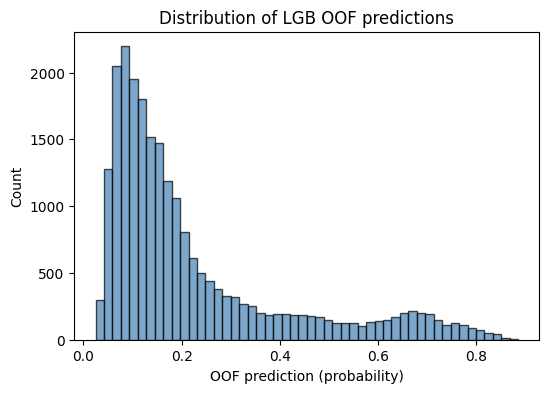

In [34]:
oof_store, test_store, auc_store = {}, {}, {}

lgb_oofs, lgb_tests, lgb_aucs = [], [], []
for sd in SEEDS:
    set_seed(sd)
    params = dict(
        objective="binary",
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        min_data_in_leaf=60,
        feature_fraction=0.9,
        bagging_fraction=0.9,
        bagging_freq=1,
        lambda_l1=0.0,
        lambda_l2=10.0,
        metric="auc",
        n_estimators=2000,
        random_state=sd,
        verbose=-1,
    )
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=sd)
    oof_pred = np.zeros(len(X_df), dtype=np.float64)
    tst_pred = np.zeros(len(X_test_df), dtype=np.float64)

    for fold, (trn_idx, val_idx) in enumerate(skf.split(X_df, y), 1):
        X_tr, y_tr = X_df.iloc[trn_idx], y[trn_idx]
        X_va, y_va = X_df.iloc[val_idx], y[val_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric="auc",
            categorical_feature=cat_cols,  # by NAME
            callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)],
        )
        oof_pred[val_idx] = model.predict_proba(X_va)[:, 1]
        tst_pred += model.predict_proba(X_test_df)[:, 1] / N_FOLDS

    lgb_oofs.append(oof_pred)
    lgb_tests.append(tst_pred)
    lgb_auc = auc(y, oof_pred)
    lgb_aucs.append(lgb_auc)
    print(f"[LGB][seed {sd}] OOF AUC = {lgb_auc:.6f}")

oof_store["lgb"] = np.vstack(lgb_oofs).mean(axis=0)
test_store["lgb"] = np.vstack(lgb_tests).mean(axis=0)
auc_store["lgb_mean_auc"] = float(np.mean(lgb_aucs))

# ================= Extra reporting block =================
import matplotlib.pyplot as plt

elapsed = time.time() - start_time
print("\n========== LGB Summary ==========")
print(f"Seeds run      : {SEEDS}")
print(f"Mean OOF AUC   : {np.mean(lgb_aucs):.6f}")
print(f"Best OOF AUC   : {np.max(lgb_aucs):.6f}")
print(f"Worst OOF AUC  : {np.min(lgb_aucs):.6f}")
print(f"Training time  : {elapsed:.1f} sec")

# Histogram of OOF predictions
plt.figure(figsize=(6,4))
plt.hist(oof_store["lgb"], bins=50, alpha=0.7, color="steelblue", edgecolor="k")
plt.xlabel("OOF prediction (probability)")
plt.ylabel("Count")
plt.title("Distribution of LGB OOF predictions")
plt.show()

**Cell 8/11 — Train XGBoost**

[XGB][seed 42] OOF AUC = 0.789008 | best_iter per fold: [95, 213, 191, 421, 506, 78, 116, 197, 133, 166]
[XGB][seed 2021] OOF AUC = 0.789083 | best_iter per fold: [77, 143, 49, 138, 163, 174, 242, 241, 209, 210]
[XGB][seed 7] OOF AUC = 0.788942 | best_iter per fold: [124, 164, 91, 89, 248, 274, 406, 106, 180, 122]
[XGB][seed 99] OOF AUC = 0.788417 | best_iter per fold: [118, 223, 217, 40, 155, 341, 215, 109, 199, 224]
[XGB][seed 1234] OOF AUC = 0.789425 | best_iter per fold: [180, 127, 151, 144, 258, 177, 102, 153, 92, 183]

========== XGB Summary ==========
Seeds run       : [42, 2021, 7, 99, 1234]
Mean OOF AUC    : 0.788975
Best OOF AUC    : 0.789425
Worst OOF AUC   : 0.788417
Mean best_iter  : 179.5
Training time   : 31.3 sec


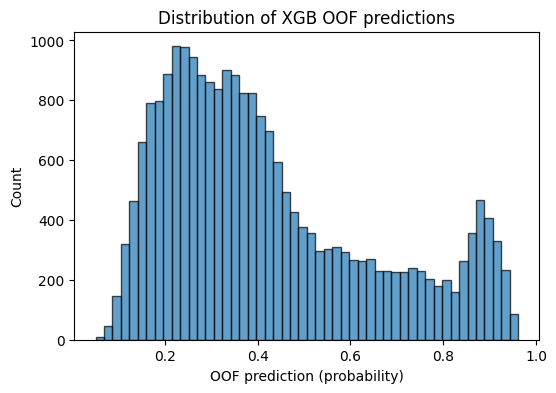

In [33]:
# ============================== CELL 8/11 (patched): Train XGBoost via xgb.train + DMatrix ==============================
"""XGBoost: dùng low-level API (xgb.train) để tương thích mọi version; có early stopping ổn định.
Giữ DataFrame end-to-end; KHÔNG downcast float."""

# Kho lưu kết quả đã khởi tạo ở cell trước: oof_store, test_store, auc_store
xgb_oofs, xgb_tests, xgb_aucs = [], [], []
xgb_best_iters = []  # lưu best_iteration cho từng seed (list of lists)

# Cân bằng lớp cho scale_pos_weight
neg, pos = (y == 0).sum(), (y == 1).sum()
spw = neg / max(pos, 1)

# Tham số cho xgb.train (native params)
base_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "eta": 0.05,
    "max_depth": 4,
    "min_child_weight": 5,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "reg_lambda": 2.0,
    "tree_method": "hist",
    "scale_pos_weight": spw,
    "nthread": -1,
}

# Reuse DMatrix cho test để nhanh hơn
dtest_global = xgb.DMatrix(X_test_df)

xgb_start = time.time()

for sd in SEEDS:
    params = dict(base_params)
    params["seed"] = sd

    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=sd)
    oof_pred = np.zeros(len(X_df), dtype=np.float64)
    tst_pred = np.zeros(len(X_test_df), dtype=np.float64)
    fold_best = []

    for fold, (trn_idx, val_idx) in enumerate(skf.split(X_df, y), 1):
        X_tr, y_tr = X_df.iloc[trn_idx], y[trn_idx]
        X_va, y_va = X_df.iloc[val_idx], y[val_idx]

        dtr = xgb.DMatrix(X_tr, label=y_tr)
        dva = xgb.DMatrix(X_va, label=y_va)

        booster = xgb.train(
            params=params,
            dtrain=dtr,
            num_boost_round=5000,
            evals=[(dva, "valid")],
            early_stopping_rounds=200,
            verbose_eval=False,  # đổi thành 100 nếu muốn xem log
        )

        # Dự đoán theo best_iteration (compat cho mọi version)
        try:
            val_pred  = booster.predict(dva,  iteration_range=(0, booster.best_iteration + 1))
            test_pred = booster.predict(dtest_global, iteration_range=(0, booster.best_iteration + 1))
            best_it = int(booster.best_iteration)
        except Exception:
            ntree = getattr(booster, "best_ntree_limit", None)
            if ntree is None:
                ntree = getattr(booster, "best_iteration", 0) + 1
            val_pred  = booster.predict(dva,  ntree_limit=ntree)
            test_pred = booster.predict(dtest_global, ntree_limit=ntree)
            best_it = int(ntree) - 1 if ntree is not None else None

        oof_pred[val_idx] = val_pred
        tst_pred += test_pred / N_FOLDS
        fold_best.append(best_it)

    xgb_oofs.append(oof_pred)
    xgb_tests.append(tst_pred)
    xgb_best_iters.append(fold_best)

    xgb_auc = auc(y, oof_pred)
    xgb_aucs.append(xgb_auc)
    print(f"[XGB][seed {sd}] OOF AUC = {xgb_auc:.6f} | best_iter per fold: {fold_best}")

# Trung bình qua seeds
oof_store["xgb"]  = np.vstack(xgb_oofs).mean(axis=0)
test_store["xgb"] = np.vstack(xgb_tests).mean(axis=0)
auc_store["xgb_mean_auc"] = float(np.mean(xgb_aucs))

# ================= Extra reporting block for XGB =================
import matplotlib.pyplot as plt

elapsed = time.time() - xgb_start
flat_best = [bi for seed_list in xgb_best_iters for bi in seed_list if bi is not None]
mean_best = (np.mean(flat_best) if len(flat_best) else np.nan)

print("\n========== XGB Summary ==========")
print(f"Seeds run       : {SEEDS}")
print(f"Mean OOF AUC    : {np.mean(xgb_aucs):.6f}")
print(f"Best OOF AUC    : {np.max(xgb_aucs):.6f}")
print(f"Worst OOF AUC   : {np.min(xgb_aucs):.6f}")
print(f"Mean best_iter  : {mean_best:.1f}" if len(flat_best) else "Mean best_iter  : n/a")
print(f"Training time   : {elapsed:.1f} sec")

plt.figure(figsize=(6,4))
plt.hist(oof_store["xgb"], bins=50, alpha=0.7, edgecolor="k")
plt.xlabel("OOF prediction (probability)")
plt.ylabel("Count")
plt.title("Distribution of XGB OOF predictions")
plt.show()


**CELL 9/11: Train CatBoost**

[CAT][seed 42] OOF AUC = 0.790561 | best_iter per fold: [227, 328, 420, 323, 418, 83, 266, 261, 233, 280]
[CAT][seed 2021] OOF AUC = 0.790603 | best_iter per fold: [203, 145, 270, 277, 239, 289, 353, 297, 250, 408]
[CAT][seed 7] OOF AUC = 0.790630 | best_iter per fold: [263, 204, 217, 206, 261, 366, 442, 265, 229, 410]
[CAT][seed 99] OOF AUC = 0.790377 | best_iter per fold: [352, 186, 409, 88, 286, 244, 373, 223, 226, 577]
[CAT][seed 1234] OOF AUC = 0.789737 | best_iter per fold: [324, 210, 195, 101, 441, 272, 222, 312, 229, 763]

========== CAT Summary ==========
Seeds run       : [42, 2021, 7, 99, 1234]
Mean OOF AUC    : 0.790381
Best OOF AUC    : 0.790630
Worst OOF AUC   : 0.789737
Mean best_iter  : 289.3
Training time   : 1684.5 sec


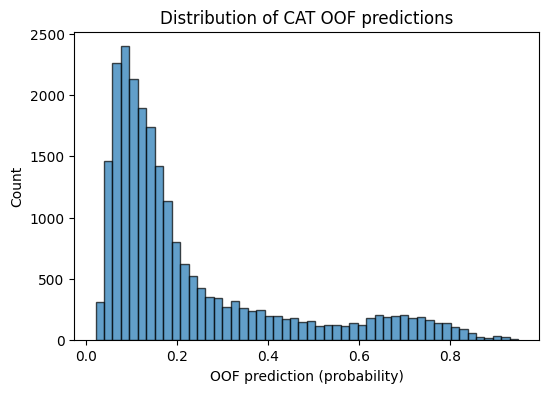

In [35]:
# ============================== CELL 9/11 (patched): Train CatBoost ==============================
"""Train CAT using Pool with cat_features by index; keep numeric floats as-is."""

# Kho lưu kết quả đã có: oof_store, test_store, auc_store
cat_oofs, cat_tests, cat_aucs = [], [], []
cat_best_iters = []  # lưu best_iteration cho từng seed (list of lists)

# Reuse test Pool để nhanh hơn
test_pool_global = Pool(
    X_test_df,
    cat_features=cat_idx if len(cat_idx) else None
)

cat_start = time.time()

for sd in SEEDS:
    set_seed(sd)
    params = dict(
        loss_function="Logloss",
        eval_metric="AUC",
        depth=6,
        learning_rate=0.05,
        l2_leaf_reg=5.0,
        random_seed=sd,
        iterations=3000,
        od_type="Iter",     # early stopping theo số vòng
        od_wait=300,        # chờ 300 vòng không cải thiện thì dừng
        task_type="CPU",
        verbose=False,
    )

    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=sd)
    oof_pred = np.zeros(len(X_df), dtype=np.float64)
    tst_pred = np.zeros(len(X_test_df), dtype=np.float64)
    fold_best = []

    for fold, (trn_idx, val_idx) in enumerate(skf.split(X_df, y), 1):
        X_tr, y_tr = X_df.iloc[trn_idx], y[trn_idx]
        X_va, y_va = X_df.iloc[val_idx], y[val_idx]

        train_pool = Pool(X_tr, y_tr, cat_features=cat_idx if len(cat_idx) else None)
        valid_pool = Pool(X_va, y_va, cat_features=cat_idx if len(cat_idx) else None)

        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

        # predict theo best iteration
        oof_pred[val_idx] = model.predict_proba(valid_pool)[:, 1]
        tst_pred += model.predict_proba(test_pool_global)[:, 1] / N_FOLDS

        # lưu best_iter của fold (nếu có)
        bi = None
        try:
            bi = int(model.get_best_iteration())
        except Exception:
            pass
        fold_best.append(bi)

    cat_oofs.append(oof_pred)
    cat_tests.append(tst_pred)
    cat_best_iters.append(fold_best)

    cat_auc = auc(y, oof_pred)
    cat_aucs.append(cat_auc)
    print(f"[CAT][seed {sd}] OOF AUC = {cat_auc:.6f} | best_iter per fold: {fold_best}")

# Trung bình qua seeds
oof_store["cat"]  = np.vstack(cat_oofs).mean(axis=0)
test_store["cat"] = np.vstack(cat_tests).mean(axis=0)
auc_store["cat_mean_auc"] = float(np.mean(cat_aucs))

# ================= Extra reporting block for CAT =================
import matplotlib.pyplot as plt

elapsed = time.time() - cat_start
flat_best = [bi for seed_list in cat_best_iters for bi in seed_list if bi is not None]
mean_best = (np.mean(flat_best) if len(flat_best) else np.nan)

print("\n========== CAT Summary ==========")
print(f"Seeds run       : {SEEDS}")
print(f"Mean OOF AUC    : {np.mean(cat_aucs):.6f}")
print(f"Best OOF AUC    : {np.max(cat_aucs):.6f}")
print(f"Worst OOF AUC   : {np.min(cat_aucs):.6f}")
print(f"Mean best_iter  : {mean_best:.1f}" if len(flat_best) else "Mean best_iter  : n/a")
print(f"Training time   : {elapsed:.1f} sec")

plt.figure(figsize=(6,4))
plt.hist(oof_store["cat"], bins=50, alpha=0.7, edgecolor="k")
plt.xlabel("OOF prediction (probability)")
plt.ylabel("Count")
plt.title("Distribution of CAT OOF predictions")
plt.show()


**Cell 10/11 — Ensemble (rank-avg) + Stacking (Logistic) + Diagnostics**

In [36]:
# ============================== CELL 10/11: Ensemble, Stack, Diagnostics ==============================
"""Rank-averaging + simple logistic stacker for robustness. You may turn off stacker if you want."""

def rank_normalize(a: np.ndarray) -> np.ndarray:
    s = pd.Series(a)
    r = s.rank(method='average')
    return ((r - 1) / (len(s) - 1)).values

# Sanity: must have at least one base model
assert len(test_store) > 0, "No base model trained. Install missing libs or check earlier cells."

base_keys = list(test_store.keys())
oof_base = np.vstack([oof_store[k] for k in base_keys]).T
TST_base = np.vstack([test_store[k] for k in base_keys]).T

# Rank-average ensemble
oof_rank = np.mean(np.column_stack([rank_normalize(oof_base[:, i]) for i in range(oof_base.shape[1])]), axis=1)
tst_rank = np.mean(np.column_stack([rank_normalize(TST_base[:, i]) for i in range(TST_base.shape[1])]), axis=1)
auc_rank = auc(y, oof_rank)
print(f"[Ensemble][RankAvg] OOF AUC = {auc_rank:.6f}")

# Simple stacker on base OOF
scaler = StandardScaler()
X_meta = scaler.fit_transform(oof_base)
meta_clf = LogisticRegression(max_iter=2000)
meta_clf.fit(X_meta, y)
oof_stack = meta_clf.predict_proba(X_meta)[:, 1]
tst_stack = meta_clf.predict_proba(scaler.transform(TST_base))[:, 1]
auc_stack = auc(y, oof_stack)
print(f"[Stack][LR] OOF AUC = {auc_stack:.6f}")

# Final blend: rank-average over (base models + stacker)
oof_all = np.column_stack([oof_base, oof_stack])
tst_all = np.column_stack([TST_base, tst_stack])
oof_final = np.mean(np.column_stack([rank_normalize(oof_all[:, i]) for i in range(oof_all.shape[1])]), axis=1)
tst_final = np.mean(np.column_stack([rank_normalize(tst_all[:, i]) for i in range(tst_all.shape[1])]), axis=1)
auc_final = auc(y, oof_final)
print(f"[FINAL][RankAvg(base+stack)] OOF AUC = {auc_final:.6f}")


[Ensemble][RankAvg] OOF AUC = 0.790950
[Stack][LR] OOF AUC = 0.791361
[FINAL][RankAvg(base+stack)] OOF AUC = 0.791118


**Cell 11/11 — Lưu submission + OOF + meta**

In [38]:
# ============================== CELL 11/11: Save Submission & Artifacts ==============================
"""Writes submission CSV, OOF diagnostics, and run metadata JSON into OUTDIR."""

# Chọn prediction cuối cùng để nộp
# (mặc định dùng tst_final từ Cell 10; có thể đổi sang tst_rank hoặc tst_stack nếu muốn)
assert 'tst_final' in globals(), "Thiếu tst_final. Hãy chạy Cell 10 trước."
assert 'test_ids' in globals(), "Thiếu test_ids (Cell 6). Hãy chạy theo thứ tự từ đầu."

# Lấy thông tin feature/shape từ đúng biến
n_train = int(X_df.shape[0])
n_test  = int(X_test_df.shape[0])
n_feat  = int(X_df.shape[1])
feat_list = list(X_df.columns)

# Lưu metadata (AUCs, seeds, models)
meta = {
    "time": timestamp(),
    "seeds": SEEDS,
    "base_models": list(test_store.keys()),
    "auc": {
        **auc_store,
        "ensemble_rank": float(auc_rank),
        "stack_lr": float(auc_stack),
        "final_rank": float(auc_final)
    },
    "train_rows": n_train,
    "test_rows": n_test,
    "n_features": n_feat,
    "features": feat_list,
}

safe_makedirs(OUTDIR)

# 1) Save meta JSON
meta_path = os.path.join(OUTDIR, f"run_meta_{timestamp()}.json")
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print(f"[OK] Meta saved to: {meta_path}")

# 2) Save OOF diagnostics
assert 'train_ids' in globals() and 'y' in globals(), "Thiếu train_ids hoặc y (Cell 6)."
assert 'base_keys' in globals(), "Thiếu base_keys (Cell 10)."

oof_df = pd.DataFrame({
    "ID": train_ids,
    "y": y,
    **{f"oof_{k}": oof_store[k] for k in base_keys},
    "oof_rank": oof_rank,
    "oof_stack": oof_stack,
    "oof_final": oof_final,
})
oof_path = os.path.join(OUTDIR, f"oof_{timestamp()}.csv")
oof_df.to_csv(oof_path, index=False)
print(f"[OK] OOF diagnostics saved to: {oof_path}")

# 3) Save submission (dùng tst_final)
submission = pd.DataFrame({
    "ID": test_ids,
    "default_payment_next_month": tst_final  # xác suất (0..1)
})
sub_path = os.path.join(OUTDIR, f"submission_{timestamp()}.csv")
submission.to_csv(sub_path, index=False)
print(f"[OK] Submission saved to: {sub_path}")

print(f"Done in {(time.time()-start_time)/60:.2f} min")

[OK] Meta saved to: ./outputs\run_meta_20250827-153644.json
[OK] OOF diagnostics saved to: ./outputs\oof_20250827-153644.csv
[OK] Submission saved to: ./outputs\submission_20250827-153644.csv
Done in 51.87 min


**EDA kết quả**

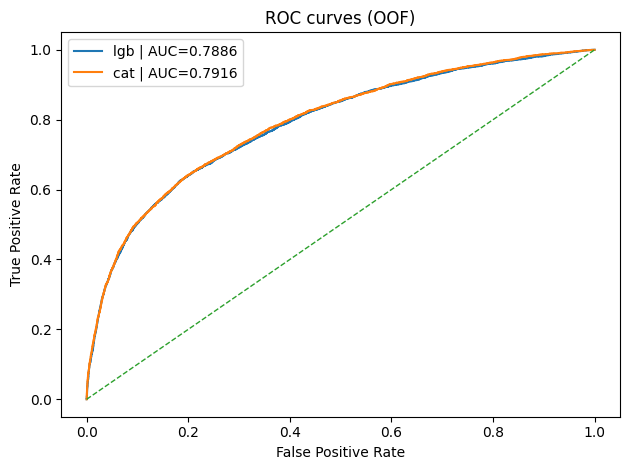

In [39]:
# ===================== DIAG CELL A: ROC curves (OOF) =====================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

assert 'oof_store' in globals(), "Không thấy oof_store. Hãy chạy xong phần train trước."
assert 'y' in globals(), "Không thấy biến y (target)."

# Chọn các key để vẽ: 3 base + (nếu có) ensemble
base_keys = [k for k in oof_store.keys() if k.lower().startswith(('lgb', 'xgb', 'cat'))]
ens_keys  = [k for k in oof_store.keys() if any(t in k.lower() for t in ['final','blend','rank','stack','ens'])]

plot_keys = []
# Ưu tiên ensemble đầu tiên (nếu có)
if ens_keys:
    # lấy key ensemble có AUC cao nhất
    best_ens = max(ens_keys, key=lambda k: roc_auc_score(y, oof_store[k]))
    plot_keys.append(best_ens)
# thêm 3 base (nếu có)
for fam in ['lgb','xgb','cat']:
    kfam = [k for k in base_keys if k.lower().startswith(fam)]
    if kfam:
        # nếu có nhiều phiên bản, lấy AUC cao nhất trong fam
        best = max(kfam, key=lambda k: roc_auc_score(y, oof_store[k]))
        plot_keys.append(best)

# Nếu chưa có gì (case hiếm), vẽ tất cả
if not plot_keys:
    plot_keys = list(oof_store.keys())

plt.figure()
for k in plot_keys:
    fpr, tpr, _ = roc_curve(y, oof_store[k])
    auc = roc_auc_score(y, oof_store[k])
    plt.plot(fpr, tpr, label=f"{k} | AUC={auc:.4f}")

plt.plot([0,1], [0,1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC curves (OOF)")
plt.legend()
plt.tight_layout()
plt.show()
